# 卷积神经网络
（convolutional neural networks）

## 从全连接层到卷积

多层感知机很适合处理表格数据，其中行对应样本，列对应特征
- 对表格数据，虽然寻找的模式可能涉及特征之间的交互，但是不能预先假设任何与特征交互相关的先验结构
- 对于**高维感知数据**，这种缺少结构的网络可能会变得不实用

### 分类猫和狗的图片
- 使用1200万像素相机采集图片（12M像素）
- RGB图片有36M元素
- 使用100大小的单隐藏层MLP，模型就有3.6B元素——远多于世界上所有猫和狗的总和
    - 3.6B参数 = 14GB

### 两个原则
- **平移不变形**：不管检测对象出现在图像中哪个位置，神经网络的前面基层应该**对相同的图像区域具有相似的反应**
- **局部性**：神经网络的前几层应该**只探索输入图像中的局部区域**，而不过度在意图像中相隔较远区域的关系
- 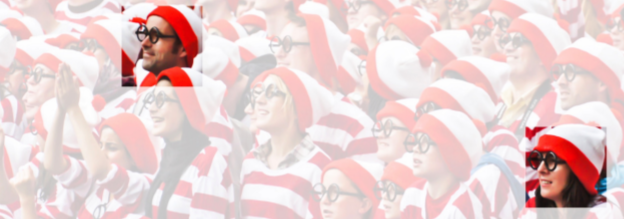

### 重新考察全连接层
- 将输入和输出变形为矩阵（高、宽）
- 将权重变形为**4-D张量**(h, w)到(h', w')
$$
h_{i,j} = \sum_{k,l}w_{i,j,k,l}x_{k,l} = \sum_{a,b}v_{i,j,a,b}x_{i+a,j+b}
$$
- V是W的**重新索引**$v_{i,j,a,b}=w_{i,j,i+a,j+b}$

### 原则1-平移不变性
- x的平移导致h的平移 $h_{i,j}=\sum_{a,b}v_{i,j,a,b}x_{i+a,j+b}$
- v**不应该依赖**于(i, j)
- 解决方案：$v_{i,j,a,b}=v_{a,b}$
$$
h_{i,j}=\sum_{a,b}v_{a,b}x_{i+a,j+b}
$$
- 这就是2维卷积（交叉相关）

### 原则2-局部性
$$
h_{i,j}=\sum_{a,b}v_{a,b}x_{i+a,j+b}
$$
- 当评估$h_{i,j}$时，不应该用远离$x_{i,j}$的参数
解决方案：当$|a|,|b|>\Delta\ $时，使得$v_{a,b}=0$

$$
h_{i,j} = \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} v_{a,b} x_{i+a,j+b}
$$

#### **交叉相关**：
用于计算一个小的过滤器（即核）子啊输入图像上滑动时的匹配程度
    - 简单而言，就是吧应该小的过滤器在输入图像上按顺序移动，然后计算每个位置上的相似性：
        - 将过滤器的每个元素与覆盖区域的对应元素相乘
        - 把这些乘积的结果加一起，得到一个值，这个值就是这个位置的输出


### **通道**
图像一般包含三个通道/三种原色（红色、绿色和蓝色）
- 图像是一个由高度、宽度和颜色组成的**三维张量**，如包含$1024\times1024\times3$个像素
    - 因此，将$\mathsf{X}$索引为$[\mathsf{X}]_{i, j, k}$
    - 卷积相应地**调整**为$[\mathsf{V}]_{a,b,c}$，而不是$[\mathbf{V}]_{a,b}$
- 通道
    -本质：每一个通道都表示一种特定的信息，**输入的通道**表示不同的颜色信息，**隐藏层的通道**表示网络在不同层次上学习到的特征
- 隐藏表示H的维度：在卷积神经网络中，**每次卷积操作**都会输出一个新的**隐藏表示**或'特征图'
    - 因为输入是3通道，所以输出的隐藏表示通常也包含多个通道，以便在卷积过程中提取到不同的特征
    - 这些通道被称为'特征映射'，可以表示不同的特征（如边缘、纹理等）
        - '特征映射'，就是一个用来**表示特征的二维矩阵**
        - **每个特征映射**都有其**独立的卷积核**进行计算，这些卷积核经过训练后可以识别图像中不同的特折
        - **低层**卷积层的特征映射通常学习到一些**简单**的特征；**更高层**卷积层的特征映射则会学习到**更加复杂**的特征
    - 隐藏表示H中的第四个坐标维度：输出的高度，输出的宽度，输出的通道数（特征映射的数量），输出在该特征映射中的位置
        - 对于彩色图像，输入通常包含三个通道，分别表示该像素在红、绿、蓝三种颜色下的强度，输入是一个“深度”为3的三维结构
        - 为了处理这个包含多个通道的输入，卷积核（filter）也必须具备相应的结构：
            - 在单通道图像（如灰度图像）中，卷积核是二维的
            - 在多通道图像中（如RGB彩色图像），卷积核扩展成三维，即高度和宽度，深度是3，以对应输入的三个通道
        - 卷积核的每个“层”分别作用于输入图像的每个通道
            - 比如红通道对应卷积核的第一层，绿通道对应卷积核的第二层，蓝通道对应卷积核的第三层
            - 每一层卷积核会与对应的通道进行交叉相关操作（像素点的逐项相乘再求和），得到一个“局部加权和”，形成一个单一的输出
        - 卷积核的第四个维度：
            - 如果希望输出有多个特征映射（即多个输出通道），我们就需要多个卷积核
            - 这些特征映射叠加起来，就形成了输出的多通道结构
            - 增加的“第四个坐标维度”就是用于表达这些不同的输出通道的
- 为了支持输入$\mathsf{X}$和隐藏表示$\mathsf{H}$中的多个通道，可以在$\mathsf{V}$中添加第四个坐标，即$[\mathsf{V}]_{a, b, c, d}$
$$
[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},
$$
其中隐藏表示$\mathsf{H}$中的索引$d$表示输出通道，而随后的输出将继续**以三维张量**$\mathsf{H}$作为输入进入下一个卷积层

### 总结
- 对**全连接层**使用**平移不变性**和**局部性**得到**卷积层**
 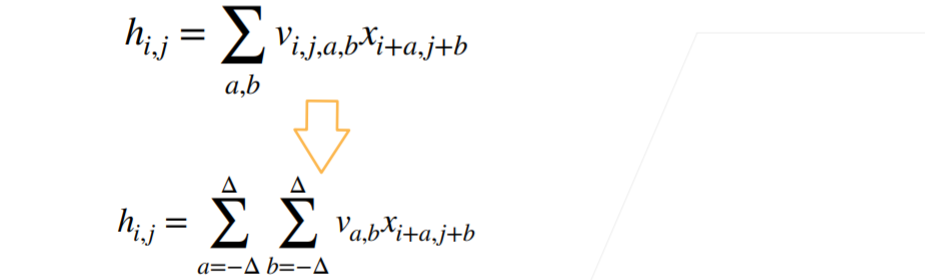
- 图像的平移不变性使我们以相同的方式处理局部图像，而**不在乎它的位置**
- 局部性意味着计算相应的隐藏表示只需**一小部分局部图像像素**
- 在图像处理中，卷积层通常比全连接层需要**更少的参数**，但依旧获得**高效用**的模型
- 卷积神经网络（CNN）是一类特殊的神经网络，它可以包含**多个卷积层**
- 多个输入和输出通道使模型在每个空间位置可以获取图像的**多方面特征**


### 练习
1. 假设卷积层覆盖的局部区域$\Delta = 0$。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层（实际就是问$1\times1$的卷积核是否等价于全连接）
- 卷积核的感受仅覆盖输入图像中每个像素点的局部位置，而**不涉及邻域**。这种情况将导致每个输出像素**仅与输入对应位置的像素相关**，而不与周围像素产生联系
- 问题的简化：假设输入图像有$C_{in}$个通道，每个通道的特征图小大小为$H \times W$
    - 卷积核大小为$1\times1$，假设卷积层有$C_{out}$个输出通道，则会有$C_{in} \times C_{out}$个参数
    - 对于位置$(i,j)$上的输出特征图$H_{i,j,l}的每个通道$l$，可以表示为
    $$
    H_{i,j,l} = \sum_{c=1}^{C_{in}}V_{c,l}X_{i,j,c} + b_l
    $
    
        - 其中$V_{c,l}$是卷积的权重，表示输入通道$c$对输出通道$l$的贡献
        - $X_{i,j,c}$是输入图像在位置$(i,j)$上第$c$通道的值
        - $b_l$是输出通道$l$的偏置
- **证明**是一个全连接层  
公式展示了每个输出通道的像素值$H_{i,j,l}$是**通过所有输入通道的加权和**计算得到的
    - 首先注意：
        - 对于每个输出位置$(i,j)$，仅依赖于输入在相同位置$(i,j)$的值
        - 权重$V_{c,l}$对所有空间位置$(i,j)$都是相同的
    - 实际上等效于在每个空间位置上，针对每个输入位置的通道执行了一个独立的全连接操作，因为每个输出通道的值是**所有输入通道**的线性组合

2. 为什么平移不变性可能也不是好主意呢？
- 平移不变形可能会降低模型的准确性和泛化能力
- 对于某些任务，平移不变性并不是必须的特征，如：图像分类任务
3. 当从图像边界像素获取隐藏表示时，我们需要思考哪些问题？
- **边界效应**：在图像边界处，卷积核会“超出”图像的范围，这导致在边界上无法正常完成卷积操作
    - 这种边界效应会造成隐藏表示在边缘位置的特征不完整，影响最终的特征提取和图像分析
- **填充策略**：在输入图像的边缘“填充”一些像素，以便在边界上也可以进行卷积操作
    - 零填充
    - 镜像填充
    - 复制填充
- 输出大小的变化：填充策略会影响卷积层输出的尺寸
    - 如果不进行填充，卷积层的输出特征图会在空间尺寸上逐层缩小，最终导致丢失图像边界上的信息
- 边缘特征的重要性：在某些任务中，图像边界的特征可能非常重要
- 计算复杂度与资源消耗
- 卷积核大小和步幅的影响：边界效应也受到卷积核大小和步幅（stride）的影响

4. 描述一个类似的音频卷积层的架构
- 一个典型的音频卷积网络架构流程如下：
    - 音频输入：原始音频转换为时频图（如梅尔频谱图）作为网络的输入。
    - 卷积层和池化层：多个卷积层和池化层堆叠，提取音频在时间和频率上的局部特征。
    - 高层卷积和全局池化：通过高层卷积层提取长时间的特征模式，通过全局池化层压缩特征。
    - 全连接层和输出层：输出层根据任务选择分类或回归的输出形式。
- 这样的音频卷积网络架构可以有效捕捉音频信号中的复杂模式和特征，适合用于多种音频分析任务
5. 卷积层也适合于文本数据吗？为什么？
- 直接问GPT
 

# 图像卷积

### 二维交叉相关
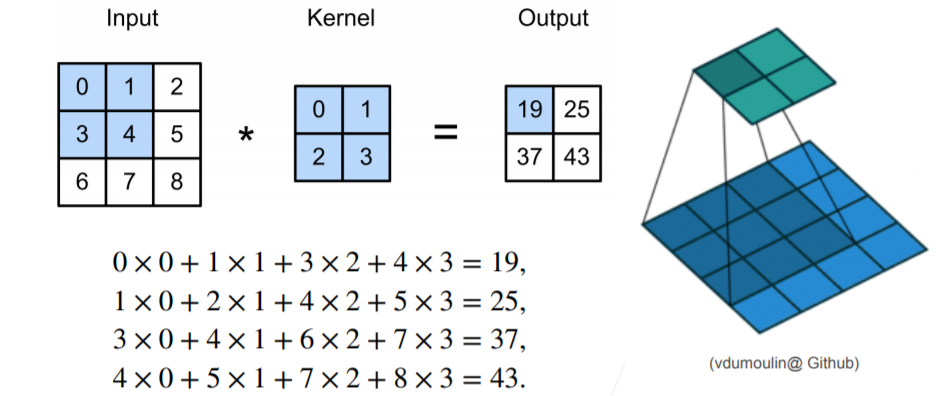

### 二维卷积层
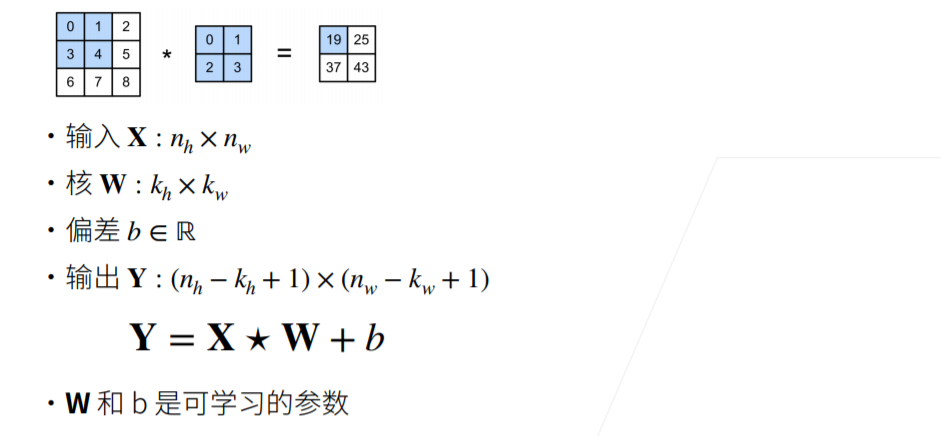

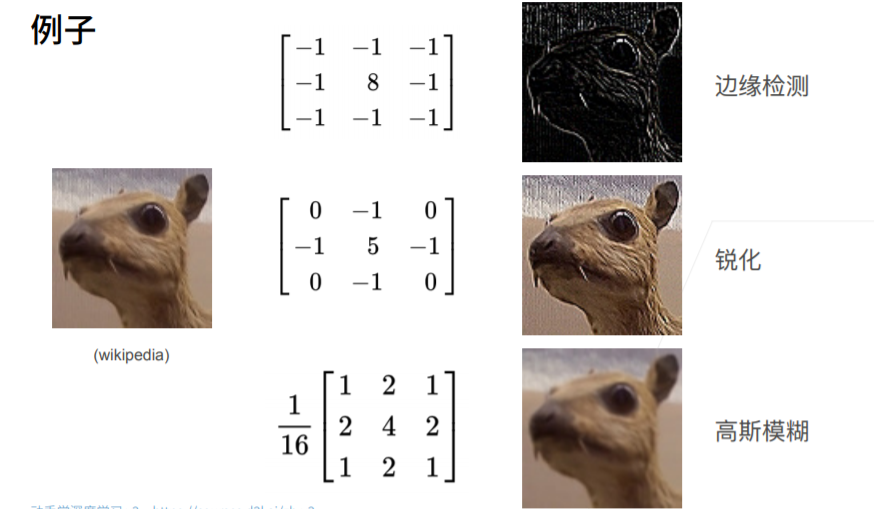

### 卷积
- 在数学中，两个函数（比如$f, g: \mathbb{R}^d \to \mathbb{R}$）之间的“卷积”被定义为
$$
(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.
$$
- 也就是说，卷积是当把一个函数“翻转”并移位$\mathbf{x}$时，测量$f$和$g$之间的重叠
- 当为离散对象时，积分就变成求和，例如，对于由索引为$\mathbb{Z}$的、平方可和的、无限维向量集合中抽取的向量
$$
(f * g)(i) = \sum_a f(a) g(i-a).
$$
- 对于二维张量，则为$f$的索引$(a, b)$和$g$的索引$(i-a, j-b)$上的对应加和：
$$
(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).
$$

### 交叉相关 vs 卷积
- 二维交叉相关
$$
y_{i,j} = \sum_{a=1}^{h} \sum_{b=1}^{w} w_{a,b} x_{i+a, j+b}
$$
- 二维卷积
$$
y_{i,j} = \sum_{a=1}^{h} \sum_{b=1}^{w} w_{-a, -b} x_{i+a, j+b}
$$
- 由于对称性，**在实际使用中没有区别**

### 一维和三维交叉相关
- 一维
$$
y_{i} = \sum_{a=1}^{h}w_{a} x_{i+a}
$$
    - 文本
    - 语言
    - 时序序列
- 三维
$$
y_{i,j,k} = \sum_{a=1}^{h} \sum_{b=1}^{w} \sum_{c=1}^{d} w_{a,b,c} x_{i+a, j+b,k+c}
$$
    - 视频
    - 医学图像
    - 气象地图


### 总结
- **卷积层**将**输入**和**核矩阵**进行**交叉相关**，加上**偏移**后得到输出
- **核矩阵**和**偏移**是**可学习的参数**
- **核矩阵的大小**是**超参数**

# 代码

### 互相关运算
严格来说，卷积层是一个错误的叫法，其所表达的运算其实是**互相关运算**（cross-correlation）
- 输入大小$n_h \times n_w$，卷积核大小$k_h \times k_w$
- 输出大小$(n_h-k_h+1) \times (n_w-k_w+1).$

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

- `X`输入数据
- `K`卷积核

In [3]:
def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - K.shape[0] + 1, X.shape[1] - K.shape[1] + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

**验证二维互相关运算的输出**

In [4]:
X = torch.tensor([[0., 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0., 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层
- 卷积层对**输入**和**卷积核**进行**互相关运算**，并在**添加标量偏置**后产生输出
- 卷积层中两个被训练的参数是**卷积核权重**和**标量偏置**
- **随机初始化**卷积核权重

**实现二维卷积层**

In [5]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, X):
        return corr2d(X, self.weigth) + self.bias

### 图像中目标的边缘检测

**卷积层的一个简单应用**：检测图像中不同颜色的边缘
- 首先构造一个$6\times8$像素的黑白图片，黑色（0），白色（1）

In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

- 再构造一个高度为1，宽度为2的卷积核`K`，当进行互相关运算时，
    - 如果水平相邻的两元素相同，输出为0
    - 如果水平相邻的两元素不相同，输出为非零
- **输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘**，其他情况的输出为$0$

In [7]:
K = torch.tensor([[1., -1]])

Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

- 卷积核`K`**只能检测垂直边缘**

In [9]:
corr2d(X.T, K)
# corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### **学习**卷积核
**学习由`X`生成`Y`的卷积核**

In [10]:
# 构造一个二维卷积层，具有1个输出通道和形状为(1, 2)的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度）
# 其中批量大小和通道数都是1
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i + 1}, loss {l.sum():.3f}')

batch 2, loss 10.547
batch 4, loss 1.785
batch 6, loss 0.306
batch 8, loss 0.054
batch 10, loss 0.010


In [11]:
conv2d.weight.data.reshape(1, 2)

tensor([[ 0.9787, -0.9876]])

### 互相关和卷积
之后继续把“互相关运算”称为**卷积运算**，尽管略有不同
- 由于卷积核是从数据中学习到的，因此无论这些层执行严格的卷积运算还是互相关运算，**卷积层的输出都不会受到影响**

### 特征映射和感受野
- 输出的卷积层有时候被称为**特征映射**，因为可以被视为一个输入映射到下一层的空间维度转换器
- **感受野**：指在前向传播期间可能影响计算`x`的所有元素
- 注意：感受野**可能大于输入的实际大小**，比如上面图片里的例子，再加一个卷积层，输出单个元素`z`，这时`z`的感受野包括图片里的输出的所有4个元素，而输入的感受野包括最初所有9个输入元素

### 小结

* 二维卷积层的**核心计算**是**二维互相关运算**。最简单的形式是，对二维输入数据和卷积核执行互相关操作，然后添加一个偏置。
* 可以设计一个卷积核来检测图像的边缘。
* 可以从数据中**学习卷积核的参数**。
* 学习卷积核时，无论用严格卷积运算或互相关运算，**卷积层的输出不会受太大影响**。
* 当需要检测输入特征中**更广**区域时，我们可以**构建一个更深的卷积网络**。

### 练习
1. 构建一个具有对角线边缘的图像`X`。
    1. 如果将本节中举例的卷积核`K`应用于`X`，会发生什么情况？
    1. 如果转置`X`会发生什么？
    1. 如果转置`K`会发生什么？

In [15]:
import torch

from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    h, w = K.shape[0], K.shape[1]
    Y = torch.zeros(X.shape[0] - K.shape[0] + 1, X.shape[1] - K.shape[1] + 1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y
    
X = torch.eye(8)
K = torch.tensor([[1., -1]])
Y = conv2d(X, K)
print(Y)

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [16]:
Y = corr2d(X.T, K)
print(Y)

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [17]:
Y = corr2d(X, K.T)
print(Y)

tensor([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])


2. 在我们创建的`Conv2D`自动求导时，有什么错误消息？
- 会提示维度不对的错误信息，因为torch提供的二维卷积层是`nn.Conv2d()`采用的是**4维输入和输出格式**（**批量大小**、**通道**、**高度**、**宽度**），而自定义的仅仅是二维的

In [19]:
class Conv2d(nn.Module):
    def __init__(self, weight_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(weight_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, X):
        return corr2d(X, self.weight) + self.bias

X = torch.ones((6, 8))
X[:, 2:6] = 0
K = torch.tensor([[1., -1]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

通过**pytorch**里的`nn.Conv2d`

In [21]:
# 学习K的值

conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for epoch in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data -= lr * conv2d.weight.grad
    if (epoch + 1) % 2 == 0:
        print(f'{epoch + 1}, loss:{l.sum():.3f}')

2, loss:1.884
4, loss:0.317
6, loss:0.054
8, loss:0.009
10, loss:0.002


使用**自己定义的**，应该怎么办

In [23]:
# 出现错误
conv2d = Conv2d(weight_size=(1, 2))
try:
    for epoch in range(10):
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
        conv2d.zero_grad()
        l.sum().backward()
        conv2d.weight.data -= lr * conv2d.weight.grad
        if (epoch + 1) % 2 == 0:
            print(f'{epoch + 1}, loss:{l.sum():.3f}')
except Exception as e :
    print(e)

The size of tensor a (0) must match the size of tensor b (7) at non-singleton dimension 3


In [24]:
X = X.reshape((6, 8))
Y = Y.reshape((6, 7))
lr = 3e-2 

for epoch in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data -= lr * conv2d.weight.grad
    if (epoch + 1) % 2 == 0:
        print(f'{epoch + 1}, loss:{l.sum():.3f}')

2, loss:12.125
4, loss:3.109
6, loss:0.962
8, loss:0.342
10, loss:0.131


- `Conv2d`继承自`nn.Module`，是**子类**，故其**所有的`nn.Parameter`类型的属性**会被自动注册为**模型的参数**，会相应的梯度正确清零、自动计算梯度

3. 如何通过改变输入张量和卷积核张量，将互相关运算表示为*矩阵乘法*?

In [26]:
def conv2d_by_mm(X, K):
    h, w = K.shape[0], K.shape[1]
    outh = X.shape[0] - h + 1
    outw = X.shape[1] - w + 1
    K = K.reshape(-1, 1)
    Y = torch.zeros(outh, outw)
    for i in range(outh):
        for j in range(outw):
            Y[i, j] = torch.mm(X[i:i + h, j:j + w].reshpe(1, -1), K)
    return Y

X = torch.ones((6, 8))
X[:, 2:6] = 0
K = torch.tensor([[1., -1]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

4. 手工设计一些卷积核。
    1. 二阶导数的核的形式是什么？
    1. 积分的核的形式是什么？
    1. 得到$d$次导数的最小核的大小是多少？
- 二阶导数的卷积核主要用于检测图像中的二阶边缘，通过用于识别亮度变化较大的区域
    -常用的有**拉普拉斯算子**
- 积分核可以用于计算像素的累计和，通常是一个具有全1的矩阵，用于计算局部区域的和
    - 实现了类似积分的效果，即累加邻域内的像素值
- 一般为了得到$d$阶导数的离散近似，**最小的核大小需要$(d+1) \times (d+1)$的**